# Language Translation
In this project, you’re going to take a peek into the realm of neural network machine translation.  You’ll be training a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French.
## Get the Data
Since translating the whole language of English to French will take lots of time to train, we have provided you with a small portion of the English corpus.

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

import helper
import problem_unittests as tests

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)

## Explore the Data
Play around with view_sentence_range to view different parts of the data.

In [2]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .

French sentences 0 to 10:
new jersey est parfois calme pendant l' automne 

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of each sentence from `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [3]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    def process_target_text(text):
        """Helper function for processing  target text."""
        for sentence in text.lower().replace('.', ' . <EOS> ').split('\n'):
            yield [target_vocab_to_int[word] for word in  sentence.strip().split()]
    
    def process_source_text(text):
        """Helper function for processing source text."""
        for sentence in text.lower().split('\n'):
            yield [source_vocab_to_int[word] for word in sentence.strip().split()]
        
    return list(process_source_text(source_text)), list(process_target_text(target_text))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
# assert LooseVersion(tf.__version__) in [LooseVersion('1.0.0'), LooseVersion('1.0.1')], 'This project requires TensorFlow version 1.0  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoding_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.

Return the placeholders in the following the tuple (Input, Targets, Learing Rate, Keep Probability)

In [7]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    :return: Tuple (input, targets, learning rate, keep probability)
    """
    inputs = tf.placeholder(tf.int32, (None, None), name='input')
    targets = tf.placeholder(tf.int32, (None, None), name='target')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    keep_probability = tf.placeholder(tf.float32, name='keep_prob')
    
    return inputs, targets, learning_rate, keep_probability

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Process Decoding Input
Implement `process_decoding_input` using TensorFlow to remove the last word id from each batch in `target_data` and concat the GO ID to the beginning of each batch.

In [8]:
def process_decoding_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for decoding
    :param target_data: Target Placeholder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    go_id = target_vocab_to_int['<GO>']
    #  np.concatenate((go_id*np.ones(batch_size).reshape(-1,1), np.array(test_target_data)[:,1:]), axis=1) # numpy
    return tf.concat((go_id*np.ones(batch_size).reshape(-1,1), target_data[:, 1:]), axis=1)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_decoding_input(process_decoding_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer using [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn).

In [9]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :return: RNN state
    """
    enc_cell = tf.contrib.rnn.MultiRNNCell([ tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(rnn_size), 
                                                                           output_keep_prob=keep_prob)] * num_layers)
    _, enc_state = tf.nn.dynamic_rnn(enc_cell, rnn_inputs, dtype=tf.float32)
    return enc_state

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create training logits using [`tf.contrib.seq2seq.simple_decoder_fn_train()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_train) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder).  Apply the `output_fn` to the [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) outputs.

In [10]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope,
                         output_fn, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param sequence_length: Sequence Length
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Train Logits
    """
    dynamic_fn_train = tf.contrib.seq2seq.simple_decoder_fn_train(encoder_state)
    outputs_train, state_train, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob), 
                                                                           dynamic_fn_train,
                                                                           inputs=dec_embed_input,
                                                                           sequence_length=sequence_length, 
                                                                           scope=decoding_scope)
    return output_fn(outputs_train) 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference logits using [`tf.contrib.seq2seq.simple_decoder_fn_inference()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_inference) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder). 

In [11]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id,
                         maximum_length, vocab_size, decoding_scope, output_fn, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param maximum_length: The maximum allowed time steps to decode
    :param vocab_size: Size of vocabulary
    :param decoding_scope: TensorFlow Variable Scope for decoding
    :param output_fn: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: Inference Logits
    """
    infer_decoder_fn = tf.contrib.seq2seq.simple_decoder_fn_inference(output_fn, encoder_state, dec_embeddings,
                                                                    start_of_sequence_id, end_of_sequence_id,
                                                                    maximum_length, vocab_size)
    inference_logits, _, _ = tf.contrib.seq2seq.dynamic_rnn_decoder(dec_cell, infer_decoder_fn, scope=decoding_scope)
    return inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

- Create RNN cell for decoding using `rnn_size` and `num_layers`.
- Create the output fuction using [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to transform it's input, logits, to class logits.
- Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope, output_fn, keep_prob)` function to get the training logits.
- Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size, decoding_scope, output_fn, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [12]:
def decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size,
                   num_layers, target_vocab_to_int, keep_prob):
    """
    Create decoding layer
    :param dec_embed_input: Decoder embedded input
    :param dec_embeddings: Decoder embeddings
    :param encoder_state: The encoded state
    :param vocab_size: Size of vocabulary
    :param sequence_length: Sequence Length
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param keep_prob: Dropout keep probability
    :return: Tuple of (Training Logits, Inference Logits)
    """
    dec_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size)]*num_layers)
    
    with tf.variable_scope("decoding") as decoding_scope:
        
        output_fn = lambda x: tf.contrib.layers.fully_connected(x, vocab_size, None, scope=decoding_scope)
        train_logits = decoding_layer_train(encoder_state, dec_cell, dec_embed_input,
                                            sequence_length, decoding_scope, output_fn, keep_prob)
        
    with tf.variable_scope("decoding", reuse=True) as decoding_scope:
    
        inference_logits = decoding_layer_infer(encoder_state, dec_cell, dec_embeddings,
                                                target_vocab_to_int['<GO>'], target_vocab_to_int['<EOS>'],
                                                sequence_length, vocab_size,
                                                decoding_scope, output_fn, keep_prob)
    return train_logits, inference_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer(decoding_layer)

Tests Passed


### Build the Neural Network
Apply the functions you implemented above to:

- Apply embedding to the input data for the encoder.
- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob)`.
- Process target data using your `process_decoding_input(target_data, target_vocab_to_int, batch_size)` function.
- Apply embedding to the target data for the decoder.
- Decode the encoded input using your `decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size, num_layers, target_vocab_to_int, keep_prob)`.

In [13]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size, sequence_length, source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param sequence_length: Sequence Length
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training Logits, Inference Logits)
    """
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size, enc_embedding_size)
    enc_state = encoding_layer(enc_embed_input, rnn_size, num_layers, keep_prob)
    processed_target_data = process_decoding_input(target_data, target_vocab_to_int, batch_size)

    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, dec_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, processed_target_data)
    
    return  decoding_layer(dec_embed_input, dec_embeddings, enc_state, target_vocab_size, sequence_length, rnn_size,
                    num_layers, target_vocab_to_int, keep_prob)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_seq2seq_model(seq2seq_model)

Tests Passed


## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability

In [113]:
len(source_vocab_to_int), len(target_vocab_to_int)

(231, 358)

In [114]:
# Number of Epochs
epochs = 5
# Batch Size
batch_size = 600
# RNN Size
rnn_size = 80
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 120
decoding_embedding_size = 160
# Learning Rate
learning_rate = 0.001
# Dropout Keep Probability
keep_probability = .8

### Build the Graph
Build the graph using the neural network you implemented.

In [115]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_source_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob = model_inputs()
    sequence_length = tf.placeholder_with_default(max_source_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)
    
    train_logits, inference_logits = seq2seq_model(
        tf.reverse(input_data, [-1]), targets, keep_prob, batch_size, sequence_length, len(source_vocab_to_int), len(target_vocab_to_int),
        encoding_embedding_size, decoding_embedding_size, rnn_size, num_layers, target_vocab_to_int)

    tf.identity(inference_logits, 'logits')
    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            train_logits,
            targets,
            tf.ones([input_shape[0], sequence_length]))

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forums to see if anyone is having the same problem.

In [116]:
train_valid_accs = []

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import time

def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1]), (0,0)],
            'constant')

    return np.mean(np.equal(target, np.argmax(logits, 2)))

train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]

valid_source = helper.pad_sentence_batch(source_int_text[:batch_size])
valid_target = helper.pad_sentence_batch(target_int_text[:batch_size])

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch) in enumerate(
                helper.batch_data(train_source, train_target, batch_size)):
            start_time = time.time()
            
            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 sequence_length: target_batch.shape[1],
                 keep_prob: keep_probability})
            
            batch_train_logits = sess.run(
                inference_logits,
                {input_data: source_batch, keep_prob: 1.0})
            batch_valid_logits = sess.run(
                inference_logits,
                {input_data: valid_source, keep_prob: 1.0})
                
            train_acc = get_accuracy(target_batch, batch_train_logits)
            valid_acc = get_accuracy(np.array(valid_target), batch_valid_logits)

            train_valid_accs.append((train_acc, valid_acc))
            end_time = time.time()
            print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.3f}, Validation Accuracy: {:>6.3f}, Loss: {:>6.3f}'
                  .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

items nbr: 137261 Batches: 228
Epoch   0 Batch    0/229 - Train Accuracy:  0.099, Validation Accuracy:  0.183, Loss:  5.879
Epoch   0 Batch    1/229 - Train Accuracy:  0.270, Validation Accuracy:  0.309, Loss:  5.767
Epoch   0 Batch    2/229 - Train Accuracy:  0.276, Validation Accuracy:  0.309, Loss:  5.662
Epoch   0 Batch    3/229 - Train Accuracy:  0.236, Validation Accuracy:  0.309, Loss:  5.601
Epoch   0 Batch    4/229 - Train Accuracy:  0.231, Validation Accuracy:  0.309, Loss:  5.521
Epoch   0 Batch    5/229 - Train Accuracy:  0.277, Validation Accuracy:  0.309, Loss:  5.373
Epoch   0 Batch    6/229 - Train Accuracy:  0.277, Validation Accuracy:  0.309, Loss:  5.276
Epoch   0 Batch    7/229 - Train Accuracy:  0.237, Validation Accuracy:  0.309, Loss:  5.254
Epoch   0 Batch    8/229 - Train Accuracy:  0.263, Validation Accuracy:  0.309, Loss:  5.105
Epoch   0 Batch    9/229 - Train Accuracy:  0.276, Validation Accuracy:  0.309, Loss:  4.984
Epoch   0 Batch   10/229 - Train Accura

Epoch   0 Batch   88/229 - Train Accuracy:  0.364, Validation Accuracy:  0.421, Loss:  2.847
Epoch   0 Batch   89/229 - Train Accuracy:  0.386, Validation Accuracy:  0.419, Loss:  2.730
Epoch   0 Batch   90/229 - Train Accuracy:  0.383, Validation Accuracy:  0.419, Loss:  2.734
Epoch   0 Batch   91/229 - Train Accuracy:  0.357, Validation Accuracy:  0.426, Loss:  2.864
Epoch   0 Batch   92/229 - Train Accuracy:  0.387, Validation Accuracy:  0.423, Loss:  2.706
Epoch   0 Batch   93/229 - Train Accuracy:  0.383, Validation Accuracy:  0.417, Loss:  2.724
Epoch   0 Batch   94/229 - Train Accuracy:  0.390, Validation Accuracy:  0.414, Loss:  2.677
Epoch   0 Batch   95/229 - Train Accuracy:  0.381, Validation Accuracy:  0.416, Loss:  2.700
Epoch   0 Batch   96/229 - Train Accuracy:  0.414, Validation Accuracy:  0.418, Loss:  2.561
Epoch   0 Batch   97/229 - Train Accuracy:  0.393, Validation Accuracy:  0.420, Loss:  2.666
Epoch   0 Batch   98/229 - Train Accuracy:  0.395, Validation Accuracy

Epoch   0 Batch  177/229 - Train Accuracy:  0.457, Validation Accuracy:  0.452, Loss:  2.186
Epoch   0 Batch  178/229 - Train Accuracy:  0.418, Validation Accuracy:  0.474, Loss:  2.372
Epoch   0 Batch  179/229 - Train Accuracy:  0.454, Validation Accuracy:  0.472, Loss:  2.243
Epoch   0 Batch  180/229 - Train Accuracy:  0.426, Validation Accuracy:  0.448, Loss:  2.273
Epoch   0 Batch  181/229 - Train Accuracy:  0.417, Validation Accuracy:  0.459, Loss:  2.339
Epoch   0 Batch  182/229 - Train Accuracy:  0.454, Validation Accuracy:  0.475, Loss:  2.237
Epoch   0 Batch  183/229 - Train Accuracy:  0.478, Validation Accuracy:  0.473, Loss:  2.113
Epoch   0 Batch  184/229 - Train Accuracy:  0.430, Validation Accuracy:  0.451, Loss:  2.252
Epoch   0 Batch  185/229 - Train Accuracy:  0.411, Validation Accuracy:  0.465, Loss:  2.347
Epoch   0 Batch  186/229 - Train Accuracy:  0.425, Validation Accuracy:  0.476, Loss:  2.324
Epoch   0 Batch  187/229 - Train Accuracy:  0.419, Validation Accuracy

Epoch   1 Batch   37/229 - Train Accuracy:  0.471, Validation Accuracy:  0.503, Loss:  1.949
Epoch   1 Batch   38/229 - Train Accuracy:  0.466, Validation Accuracy:  0.496, Loss:  1.894
Epoch   1 Batch   39/229 - Train Accuracy:  0.435, Validation Accuracy:  0.486, Loss:  1.973
Epoch   1 Batch   40/229 - Train Accuracy:  0.509, Validation Accuracy:  0.505, Loss:  1.780
Epoch   1 Batch   41/229 - Train Accuracy:  0.490, Validation Accuracy:  0.506, Loss:  1.844
Epoch   1 Batch   42/229 - Train Accuracy:  0.428, Validation Accuracy:  0.477, Loss:  1.921
Epoch   1 Batch   43/229 - Train Accuracy:  0.474, Validation Accuracy:  0.503, Loss:  1.873
Epoch   1 Batch   44/229 - Train Accuracy:  0.477, Validation Accuracy:  0.499, Loss:  1.858
Epoch   1 Batch   45/229 - Train Accuracy:  0.435, Validation Accuracy:  0.480, Loss:  1.931
Epoch   1 Batch   46/229 - Train Accuracy:  0.481, Validation Accuracy:  0.501, Loss:  1.839
Epoch   1 Batch   47/229 - Train Accuracy:  0.443, Validation Accuracy

Epoch   1 Batch  126/229 - Train Accuracy:  0.445, Validation Accuracy:  0.472, Loss:  1.532
Epoch   1 Batch  127/229 - Train Accuracy:  0.450, Validation Accuracy:  0.477, Loss:  1.502
Epoch   1 Batch  128/229 - Train Accuracy:  0.482, Validation Accuracy:  0.477, Loss:  1.417
Epoch   1 Batch  129/229 - Train Accuracy:  0.448, Validation Accuracy:  0.476, Loss:  1.498
Epoch   1 Batch  130/229 - Train Accuracy:  0.446, Validation Accuracy:  0.475, Loss:  1.479
Epoch   1 Batch  131/229 - Train Accuracy:  0.421, Validation Accuracy:  0.475, Loss:  1.559
Epoch   1 Batch  132/229 - Train Accuracy:  0.470, Validation Accuracy:  0.472, Loss:  1.401
Epoch   1 Batch  133/229 - Train Accuracy:  0.451, Validation Accuracy:  0.470, Loss:  1.452
Epoch   1 Batch  134/229 - Train Accuracy:  0.451, Validation Accuracy:  0.472, Loss:  1.460
Epoch   1 Batch  135/229 - Train Accuracy:  0.447, Validation Accuracy:  0.476, Loss:  1.448
Epoch   1 Batch  136/229 - Train Accuracy:  0.448, Validation Accuracy

Epoch   1 Batch  215/229 - Train Accuracy:  0.356, Validation Accuracy:  0.405, Loss:  1.126
Epoch   1 Batch  216/229 - Train Accuracy:  0.369, Validation Accuracy:  0.399, Loss:  1.085
Epoch   1 Batch  217/229 - Train Accuracy:  0.391, Validation Accuracy:  0.395, Loss:  1.040
Epoch   1 Batch  218/229 - Train Accuracy:  0.352, Validation Accuracy:  0.392, Loss:  1.097
Epoch   1 Batch  219/229 - Train Accuracy:  0.366, Validation Accuracy:  0.393, Loss:  1.093
Epoch   1 Batch  220/229 - Train Accuracy:  0.370, Validation Accuracy:  0.393, Loss:  1.083
Epoch   1 Batch  221/229 - Train Accuracy:  0.369, Validation Accuracy:  0.392, Loss:  1.066
Epoch   1 Batch  222/229 - Train Accuracy:  0.327, Validation Accuracy:  0.393, Loss:  1.122
Epoch   1 Batch  223/229 - Train Accuracy:  0.363, Validation Accuracy:  0.392, Loss:  1.076
Epoch   1 Batch  224/229 - Train Accuracy:  0.331, Validation Accuracy:  0.391, Loss:  1.104
Epoch   1 Batch  225/229 - Train Accuracy:  0.334, Validation Accuracy

Epoch   2 Batch   75/229 - Train Accuracy:  0.309, Validation Accuracy:  0.334, Loss:  0.776
Epoch   2 Batch   76/229 - Train Accuracy:  0.318, Validation Accuracy:  0.338, Loss:  0.774
Epoch   2 Batch   77/229 - Train Accuracy:  0.317, Validation Accuracy:  0.340, Loss:  0.772
Epoch   2 Batch   78/229 - Train Accuracy:  0.316, Validation Accuracy:  0.339, Loss:  0.753
Epoch   2 Batch   79/229 - Train Accuracy:  0.339, Validation Accuracy:  0.338, Loss:  0.747
Epoch   2 Batch   80/229 - Train Accuracy:  0.314, Validation Accuracy:  0.334, Loss:  0.773
Epoch   2 Batch   81/229 - Train Accuracy:  0.312, Validation Accuracy:  0.333, Loss:  0.755
Epoch   2 Batch   82/229 - Train Accuracy:  0.307, Validation Accuracy:  0.334, Loss:  0.763
Epoch   2 Batch   83/229 - Train Accuracy:  0.315, Validation Accuracy:  0.335, Loss:  0.751
Epoch   2 Batch   84/229 - Train Accuracy:  0.273, Validation Accuracy:  0.335, Loss:  0.796
Epoch   2 Batch   85/229 - Train Accuracy:  0.314, Validation Accuracy

Epoch   2 Batch  164/229 - Train Accuracy:  0.249, Validation Accuracy:  0.310, Loss:  0.569
Epoch   2 Batch  165/229 - Train Accuracy:  0.287, Validation Accuracy:  0.314, Loss:  0.544
Epoch   2 Batch  166/229 - Train Accuracy:  0.282, Validation Accuracy:  0.314, Loss:  0.540
Epoch   2 Batch  167/229 - Train Accuracy:  0.289, Validation Accuracy:  0.314, Loss:  0.539
Epoch   2 Batch  168/229 - Train Accuracy:  0.251, Validation Accuracy:  0.313, Loss:  0.549
Epoch   2 Batch  169/229 - Train Accuracy:  0.242, Validation Accuracy:  0.308, Loss:  0.568
Epoch   2 Batch  170/229 - Train Accuracy:  0.270, Validation Accuracy:  0.305, Loss:  0.530
Epoch   2 Batch  171/229 - Train Accuracy:  0.249, Validation Accuracy:  0.306, Loss:  0.550
Epoch   2 Batch  172/229 - Train Accuracy:  0.285, Validation Accuracy:  0.310, Loss:  0.521
Epoch   2 Batch  173/229 - Train Accuracy:  0.261, Validation Accuracy:  0.314, Loss:  0.554
Epoch   2 Batch  174/229 - Train Accuracy:  0.252, Validation Accuracy

Epoch   3 Batch   24/229 - Train Accuracy:  0.223, Validation Accuracy:  0.300, Loss:  0.393
Epoch   3 Batch   25/229 - Train Accuracy:  0.267, Validation Accuracy:  0.300, Loss:  0.358
Epoch   3 Batch   26/229 - Train Accuracy:  0.269, Validation Accuracy:  0.301, Loss:  0.363
Epoch   3 Batch   27/229 - Train Accuracy:  0.268, Validation Accuracy:  0.300, Loss:  0.358
Epoch   3 Batch   28/229 - Train Accuracy:  0.273, Validation Accuracy:  0.302, Loss:  0.349
Epoch   3 Batch   29/229 - Train Accuracy:  0.270, Validation Accuracy:  0.302, Loss:  0.361
Epoch   3 Batch   30/229 - Train Accuracy:  0.265, Validation Accuracy:  0.301, Loss:  0.361
Epoch   3 Batch   31/229 - Train Accuracy:  0.275, Validation Accuracy:  0.301, Loss:  0.364
Epoch   3 Batch   32/229 - Train Accuracy:  0.267, Validation Accuracy:  0.301, Loss:  0.356
Epoch   3 Batch   33/229 - Train Accuracy:  0.264, Validation Accuracy:  0.300, Loss:  0.361
Epoch   3 Batch   34/229 - Train Accuracy:  0.231, Validation Accuracy

Epoch   3 Batch  113/229 - Train Accuracy:  0.263, Validation Accuracy:  0.297, Loss:  0.245
Epoch   3 Batch  114/229 - Train Accuracy:  0.274, Validation Accuracy:  0.297, Loss:  0.236
Epoch   3 Batch  115/229 - Train Accuracy:  0.218, Validation Accuracy:  0.296, Loss:  0.266
Epoch   3 Batch  116/229 - Train Accuracy:  0.227, Validation Accuracy:  0.297, Loss:  0.271
Epoch   3 Batch  117/229 - Train Accuracy:  0.231, Validation Accuracy:  0.297, Loss:  0.257
Epoch   3 Batch  118/229 - Train Accuracy:  0.263, Validation Accuracy:  0.296, Loss:  0.237
Epoch   3 Batch  119/229 - Train Accuracy:  0.266, Validation Accuracy:  0.296, Loss:  0.239
Epoch   3 Batch  120/229 - Train Accuracy:  0.231, Validation Accuracy:  0.296, Loss:  0.250
Epoch   3 Batch  121/229 - Train Accuracy:  0.265, Validation Accuracy:  0.297, Loss:  0.227
Epoch   3 Batch  122/229 - Train Accuracy:  0.227, Validation Accuracy:  0.297, Loss:  0.245
Epoch   3 Batch  123/229 - Train Accuracy:  0.260, Validation Accuracy

Epoch   3 Batch  202/229 - Train Accuracy:  0.268, Validation Accuracy:  0.306, Loss:  0.170
Epoch   3 Batch  203/229 - Train Accuracy:  0.280, Validation Accuracy:  0.305, Loss:  0.175
Epoch   3 Batch  204/229 - Train Accuracy:  0.274, Validation Accuracy:  0.305, Loss:  0.170
Epoch   3 Batch  205/229 - Train Accuracy:  0.343, Validation Accuracy:  0.304, Loss:  0.159
Epoch   3 Batch  206/229 - Train Accuracy:  0.275, Validation Accuracy:  0.307, Loss:  0.176
Epoch   3 Batch  207/229 - Train Accuracy:  0.279, Validation Accuracy:  0.308, Loss:  0.154
Epoch   3 Batch  208/229 - Train Accuracy:  0.276, Validation Accuracy:  0.309, Loss:  0.168
Epoch   3 Batch  209/229 - Train Accuracy:  0.268, Validation Accuracy:  0.307, Loss:  0.173
Epoch   3 Batch  210/229 - Train Accuracy:  0.237, Validation Accuracy:  0.307, Loss:  0.181
Epoch   3 Batch  211/229 - Train Accuracy:  0.276, Validation Accuracy:  0.308, Loss:  0.170
Epoch   3 Batch  212/229 - Train Accuracy:  0.310, Validation Accuracy

Epoch   4 Batch   62/229 - Train Accuracy:  0.304, Validation Accuracy:  0.302, Loss:  0.128
Epoch   4 Batch   63/229 - Train Accuracy:  0.237, Validation Accuracy:  0.302, Loss:  0.125
Epoch   4 Batch   64/229 - Train Accuracy:  0.269, Validation Accuracy:  0.301, Loss:  0.120
Epoch   4 Batch   65/229 - Train Accuracy:  0.263, Validation Accuracy:  0.298, Loss:  0.130
Epoch   4 Batch   66/229 - Train Accuracy:  0.267, Validation Accuracy:  0.296, Loss:  0.120
Epoch   4 Batch   67/229 - Train Accuracy:  0.262, Validation Accuracy:  0.297, Loss:  0.124
Epoch   4 Batch   68/229 - Train Accuracy:  0.271, Validation Accuracy:  0.298, Loss:  0.122
Epoch   4 Batch   69/229 - Train Accuracy:  0.273, Validation Accuracy:  0.302, Loss:  0.135
Epoch   4 Batch   70/229 - Train Accuracy:  0.276, Validation Accuracy:  0.305, Loss:  0.118
Epoch   4 Batch   71/229 - Train Accuracy:  0.241, Validation Accuracy:  0.305, Loss:  0.125
Epoch   4 Batch   72/229 - Train Accuracy:  0.261, Validation Accuracy

Epoch   4 Batch  151/229 - Train Accuracy:  0.295, Validation Accuracy:  0.300, Loss:  0.088
Epoch   4 Batch  152/229 - Train Accuracy:  0.264, Validation Accuracy:  0.300, Loss:  0.092
Epoch   4 Batch  153/229 - Train Accuracy:  0.262, Validation Accuracy:  0.302, Loss:  0.097
Epoch   4 Batch  154/229 - Train Accuracy:  0.279, Validation Accuracy:  0.302, Loss:  0.098
Epoch   4 Batch  155/229 - Train Accuracy:  0.266, Validation Accuracy:  0.301, Loss:  0.097
Epoch   4 Batch  156/229 - Train Accuracy:  0.354, Validation Accuracy:  0.299, Loss:  0.079
Epoch   4 Batch  157/229 - Train Accuracy:  0.267, Validation Accuracy:  0.298, Loss:  0.098
Epoch   4 Batch  158/229 - Train Accuracy:  0.231, Validation Accuracy:  0.299, Loss:  0.091
Epoch   4 Batch  159/229 - Train Accuracy:  0.270, Validation Accuracy:  0.300, Loss:  0.091
Epoch   4 Batch  160/229 - Train Accuracy:  0.244, Validation Accuracy:  0.302, Loss:  0.095
Epoch   4 Batch  161/229 - Train Accuracy:  0.277, Validation Accuracy

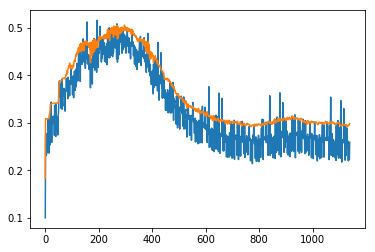

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline
t_acc, valid_acc = zip(*train_valid_accs)
plt.plot(t_acc)
plt.plot(valid_acc)

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [118]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path) 

# Checkpoint

In [119]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
- Convert words not in the vocabulary, to the `<UNK>` word id.

In [120]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    return [vocab_to_int.get(word, vocab_to_int.get('<UNK>')) for word in sentence.split()]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [121]:
translate_sentence = 'he saw a old yellow truck .'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('logits:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence], keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  English Words: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in np.argmax(translate_logits, 1)]))
print('  French Words: {}'.format([target_int_to_vocab[i] for i in np.argmax(translate_logits, 1)]))

Input
  Word Ids:      [48, 178, 142, 88, 40, 96, 169]
  English Words: ['he', 'saw', 'a', 'old', 'yellow', 'truck', '.']

Prediction
  Word Ids:      [331, 331, 331, 331, 331, 331, 331, 331, 345, 345, 345, 345, 345, 0, 0, 0, 0, 0]
  French Words: ['il', 'il', 'il', 'il', 'il', 'il', 'il', 'il', '.', '.', '.', '.', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [122]:
source_int_to_vocab

{0: '<PAD>',
 1: '<EOS>',
 2: '<UNK>',
 3: '<GO>',
 4: 'lime.',
 5: 'why',
 6: 'we',
 7: 'lemons.',
 8: 'weather',
 9: 'bears',
 10: 'chilly',
 11: 'dry',
 12: 'cats',
 13: 'busy',
 14: 'car',
 15: 'birds',
 16: 'sometimes',
 17: 'during',
 18: 'april',
 19: 'nice',
 20: 'quiet',
 21: 'cat',
 22: 'mangoes',
 23: 'june',
 24: 'but',
 25: 'usually',
 26: 'liked.',
 27: 'drove',
 28: 'mangoes.',
 29: 'snake',
 30: 'grape.',
 31: 'are',
 32: 'february',
 33: 'beautiful',
 34: 'how',
 35: 'when',
 36: 'oranges',
 37: 'plan',
 38: 'going',
 39: 'apple',
 40: 'yellow',
 41: 'want',
 42: 'lemon',
 43: 'lions',
 44: 'lion',
 45: 'have',
 46: 'lake',
 47: 'mild',
 48: 'he',
 49: 'little',
 50: 'warm',
 51: 'relaxing',
 52: 'liked',
 53: 'grapefruit',
 54: 'to',
 55: 'apple.',
 56: 'august',
 57: 'loved.',
 58: 'winter',
 59: 'lime',
 60: 'i',
 61: 'peach.',
 62: 'fruit.',
 63: 'shark',
 64: 'mice',
 65: 'animals',
 66: 'california',
 67: 'shiny',
 68: 'that',
 69: 'green',
 70: 'july',
 71: 'mon

In [123]:
def translate_sentence(sentence, source_vocab_to_int):
    s2seq = sentence_to_seq(sentence, source_vocab_to_int)
    print(s2seq)
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # Load saved model
        loader = tf.train.import_meta_graph(load_path + '.meta')
        loader.restore(sess, load_path)

        input_data = loaded_graph.get_tensor_by_name('input:0')
        logits = loaded_graph.get_tensor_by_name('logits:0')
        keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

        translate_logits = sess.run(logits, {input_data: [s2seq], keep_prob: 1.0})[0]

    print('Input')
    print('  Word Ids:      {}'.format([i for i in s2seq]))
    print('  English Words: {}'.format([source_int_to_vocab[i] for i in s2seq]))

    print('\nPrediction')
    print('  Word Ids:      {}'.format([i for i in np.argmax(translate_logits, 1)]))
    print('  French Words: {}'.format([target_int_to_vocab[i] for i in np.argmax(translate_logits, 1)]))

In [124]:
translate_sentence("we like peaches", source_vocab_to_int)

[6, 116, 205]
Input
  Word Ids:      [6, 116, 205]
  English Words: ['we', 'like', 'peaches']

Prediction
  Word Ids:      [325, 325, 325, 325, 325, 325, 345, 345, 345, 345, 0, 0, 0, 0, 0, 0, 0, 0]
  French Words: ['plus', 'plus', 'plus', 'plus', 'plus', 'plus', '.', '.', '.', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


## Imperfect Translation
You might notice that some sentences translate better than others.  Since the dataset you're using only has a vocabulary of 227 English words of the thousands that you use, you're only going to see good results using these words.  Additionally, the translations in this data set were made by Google translate, so the translations themselves aren't particularly good.  (We apologize to the French speakers out there!) Thankfully, for this project, you don't need a perfect translation. However, if you want to create a better translation model, you'll need better data.

You can train on the [WMT10 French-English corpus](http://www.statmt.org/wmt10/training-giga-fren.tar).  This dataset has more vocabulary and richer in topics discussed.  However, this will take you days to train, so make sure you've a GPU and the neural network is performing well on dataset we provided.  Just make sure you play with the WMT10 corpus after you've submitted this project.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_language_translation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.